# Introduction & data set

Males of many birds sing elaborated songs consisting of various distinct sounds called syllables. Each individual has finite repertoire of different syllables that can be grupped in the clearly separated song bouts. I studied the song of the bluethroat, *Luscinia svecica* - small, secretive bird closely related to nightingales, well-known for their complicated song. I used separate, uninterrupted recordings of bluethroats of known age, indexed all the song bouts in the recordings, split the songs into syllables and classified them to distinct syllable types. In every recording each syllable type was given a unique number and repertoire of each bird was saved in separate .csv file. Data in files ending with 'y.*csv*' refers to young birds, while file names ending with 'a.*csv*' refers to adults. For every syllable (row):
1. column gives the number of the song bout
2. column gives a number of syllable type
 
We want to examine whether there are any differences in the song repertoire size between young males breeding for the first time and adult, experienced individuals. 

# Data loading

Let's read data for all young birds at once using fast *pd.read* command and keeping original file names:

In [1]:
import pandas as pd
import glob

young = pd.concat([pd.read_csv(f, sep=';', names=(f'song{f[5:11]}',f'syllable{f[5:11]}')) for f in glob.glob("Data\*y.csv")],
                  axis=1, ignore_index=0)
young.head()

,song01-74y,syllable01-74y,song01-84y,syllable01-84y,song06-07y,syllable06-07y,song06-22y,syllable06-22y,song08-00y,syllable08-00y,song09-27y,syllable09-27y,song13-10y,syllable13-10y,song15-00y,syllable15-00y,song16-08y,syllable16-08y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,2,1.0,1.0,1.0,1.0
3,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1,3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1,1,1.0,1.0,1.0,2.0


Let's get rid of unnecessary first columns of every file:

In [2]:
young = young.iloc[:,1::2]

Let's load data for adults:

In [3]:
adult = pd.concat([pd.read_csv(f, sep=';', names=(f'song{f[:-6]}',f'{f[5:11]}')) for f in glob.glob("Data\*a.csv")], axis=1,
                      ignore_index=0)
adult = adult.iloc[:,1::2]

To find repertoire size we will loop trough the data to find the number of unique values in different syllable sequences. We could do it using *pd.unique* for sliced columns of *pandas* data frame, however we'd rather create a list of arrays for which we can directly use *np.unique*.

In this example the efficiency & performance is not an issue but in real world, with much larger data sets the *NumPy* approach clearly beats the *pandas* one, being at least 100 times faster. 

In [4]:
import numpy as np

# list of arrays for adults
adult_birds = []

for bird in adult.columns.values:
    bird = adult[bird].values
    bird = bird[~np.isnan(bird)]
    adult_birds.append(bird)
    # By the way, we can describe song syllable sequence for each bird in the list, as we loop
    print(f'{bird.size} total syllables of {len(np.unique(bird))} different types')

2134 total syllables of 158 different types
2772 total syllables of 177 different types
2977 total syllables of 202 different types
2969 total syllables of 207 different types
1486 total syllables of 113 different types
2061 total syllables of 192 different types
2550 total syllables of 176 different types
3408 total syllables of 213 different types


In [5]:
young_birds = []
for bird in young.columns.values:
    bird = young[bird].values
    bird = bird[~np.isnan(bird)]
    young_birds.append(bird)
#     print(f'{bird.size} total syllables of {len(np.unique(bird))} different types')

Instead of printing the values, let's simply plot the total repertoire size vs. the length of analysed syllable sequence.

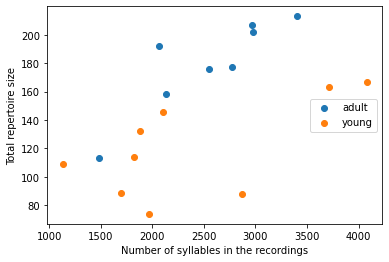

In [6]:
import matplotlib.pyplot as plt

x_adult = [len(bird) for bird in adult_birds]
y_adult = [len(np.unique(bird)) for bird in adult_birds]

x_young = [len(bird) for bird in young_birds]
y_young = [len(np.unique(bird)) for bird in young_birds]

fig, ax = plt.subplots()

ax.scatter(x_adult, y_adult, label='adult')
ax.scatter(x_young, y_young, label='young')

ax.set_ylabel('Total repertoire size')
ax.set_xlabel('Number of syllables in the recordings')
ax.legend(loc='center right')

plt.show()

There seems to be rather obvious positive relationship between the total repertoire size and the length of the recording. 

# Estimating the repertoire size

## Capture-recapture method

If we naively measure repertoire size of each bird as the total number of different syllables in the corresponding recording, the result would certainly depend on the length of the recording.

To deal with the problem of uneven length of recordings, we can use simple capture-recapture method. We are going to estimate repertoire size for each recording from sample of several sequences of fixed length. First sequence starts from the first element and ends with nth element. The next starts, for example, at 10th element and ends at nth+10 element, etc. For each successive sequence we write the number of different syllables. Finally, we can use the arithmetic mean of listed values as the reliable estimator of the repertoire size.

In [7]:
# Counts number of different elements in sample starting from lower_range index up to upper_range,
# than moves the frame and examining next sample of the same length starting from lower_range + step.

def repertoire_size (syllable_series, lower_range=0, upper_range=1000, step=10):

    rep = []
    for x in range(upper_range, syllable_series.size, step):
        rep.append(np.unique(syllable_series[lower_range:upper_range]).size)
        lower_range += step
        upper_range += step
        
    repertoire = np.array(rep)
    
    return np.mean(repertoire), np.min(repertoire), np.max(repertoire)

# We can calculate repertoire for group of birds at once

def group_repertoire (birds):  
    
    result = []
    for bird in birds:
        result.append(list(repertoire_size(bird)))
        
    return result

## Repertoire estimate for each age class

In [8]:
answer_young = np.array(group_repertoire(young_birds))
answer_adult = np.array(group_repertoire(adult_birds))

In [9]:
print(f'Repertoire of each young bird (Mean\Minimum\Maximum):\n{answer_young}\n')
print(f'Repertoire of each adult bird (Mean\Minimum\Maximum):\n{answer_adult}')

Repertoire of each young bird (Mean\Minimum\Maximum):
[[106.18382353  75.         129.        ]
 [ 70.05882353  62.          76.        ]
 [107.23423423 101.         116.        ]
 [101.53846154  96.         106.        ]
 [ 60.18556701  54.          66.        ]
 [ 98.23863636  90.         112.        ]
 [102.63430421  78.         119.        ]
 [ 98.75609756  92.         107.        ]
 [ 83.58571429  80.          86.        ]]

Repertoire of each adult bird (Mean\Minimum\Maximum):
[[103.92982456  91.         116.        ]
 [121.99438202 110.         132.        ]
 [120.23737374 100.         138.        ]
 [124.8680203   91.         139.        ]
 [ 96.73469388  93.         104.        ]
 [135.51401869 113.         149.        ]
 [124.6        115.         146.        ]
 [132.36099585 116.         148.        ]]


## Conclusion

Let's visualise the difference in the repertoire size between age groups

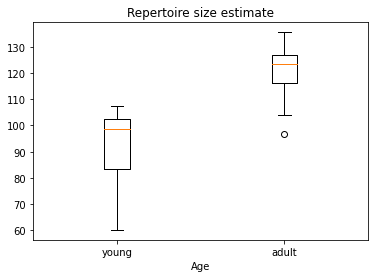

In [10]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

labels = ['young', 'adult']

fig, ax = plt.subplots()

ax.set_title('Repertoire size estimate')
ax.boxplot([answer_young[:,0], answer_adult[:,0]])
ax.set_xticklabels(labels)

plt.xlabel('Age')
plt.show()

Let's test the above difference with Mann-Whitney U test

In [11]:
from scipy.stats import mannwhitneyu

w, p = mannwhitneyu(answer_young[:,0], answer_adult[:,0])

print(f'The song repertoire size of adults was significantly larger than that of youngs (W = {w}, p = {round(p, 3)}).')

The song repertoire size of adults was significantly larger than that of youngs (W = 8.0, p = 0.004).


**Now we know that adult birds have larger repertoire than young ones.**

This result may suggest that song repertoire increases with age in the bluethroat, but it's a completely different story...